# Electronic Markets - Optimal execution with the Almgren-Chriss model

## 1. Model

The **Almgren-Chriss framework** (1999) is a mathematical model that looks to estimate the optimal pace to build/unwind a trading position, issues often faced by brokers and traders but has not seen as much interest from statisticians, economists and econophysicists in the past decades. Compared to Bertsimas-Lo (1998), Almgren-Chriss established the existence of a trade-off between fast execution (limited liquidity, high market impact, high transaction costs) and slow execution (exposure to price fluctuations). Other interesting facets of the Almgren-Chriss framework include:

- Allows one to graphically represent the trade-off between slow/fast execution;
- Ease to choose one's own prefered approach to model market impact costs;
- Avoids the temptation of modelling the market as a physical system fully enclosed in its own data (*physics envy*);
- Designed from a bottom-top approach: the modelling is based on the execution process itself;
- Provides a multitude of modelling approaches to compute the slow/fast execution trade-off (e.g. dynamic programming, stochastic control, reinforcement learning, etc.).

We will present 4 approaches to solve the Almgren-Chriss mode:

1. Dynamic programming
2. Closed-form solution (original method)
3. Stochastic control
4. Reinforcement learning (ex. Q-Learning)


## 2. Dynamic programming

### 2.1. Market impact functions

In [3]:
import numpy as np
import pandas as pd
import math

Utilities for the implementation of Almgren-Chriss:

- **Temporary market impact function**

$$ h(\frac{n_k}{\tau}) = \epsilon \, sign(n_k) + \eta \frac{n_k}{\tau} $$

- **Permanent market impact function**

$$ g(v) = \gamma v $$

- **Hamiltonian equation**

$$ H(x,n) = ng(\frac{n}{\tau}) + \gamma (x-n) \tau h(\frac{n}{\tau}) - \frac{1}{2} \gamma^2 (x-n)^2 \sigma^2 \tau $$

In [4]:
# Utilities
def h(u):
    """
    Temporary market impact function.
    
    Inputs
    - u/tau, speed of trading
    """
    tau = 1.
    epsilon = 1./16.
    eta = 2.5 * 10 ** (-3)
    return epsilon * np.sign(u) + eta * (u/tau)

def g(u):
    """
    Permanent market impact function.
    """
    gamma = 2.5 * 10 ** (-3)
    return gamma * u

def H(x,n):
    """
    Hamiltonian equation. To be minimized through DP.
    """
    tau = 1.
    gamma = 2.5 * 10 ** (-3)
    sigma = 0.3
    res = n*g(n/tau) + gamma*(x-n)*tau*h(n/tau) - 0.5*(gamma**2)*(sigma**2)*tau
    return res

### 2.2. Dynamic programming: a simplified version

Bellman equation:

In [5]:
def dynamic_programming(nb_T, X_total):
    """
    Bellman equation for solving Markov decision processes.
    
    Inputs
    - nb_T, number of time steps
    - X_total, number of shares to be liquidated
    """
    # Init
    tau = 1.
    gamma = 2.5 * 10 ** (-5)
    u = np.zeros(shape=(nb_T, X_total), dtype="float")  # value function
    b = np.zeros(shape=(nb_T, X_total), dtype="int")    # best move
    
    # Terminal condition
    for x in range(X_total):
        u[nb_T - 1, x] = math.exp(gamma*x*h(x/tau))
        b[nb_T - 1, x] = x
    
    # Backwards induction
    for t in range(nb_T-2, -1, -1):
        for x in range(X_total):
            
            best_value = u[t+1,0] * math.exp(gamma*H(x,x))
            best_n = x
            
            for n in range(x):
                current_value = u[t+1,x-n] * math.exp(gamma*H(x,n))
                if current_value < best_value:
                    best_value = current_value
                    best_n = n
            u[t,x] = best_value
            b[t,x] = best_n
    
    return u, b

In [21]:
model = dynamic_programming(nb_T=10, X_total=50)
print(model[0].shape)
#pd.DataFrame(model[0])
#model[0]

(10, 50)


In [22]:
#print(model[1])

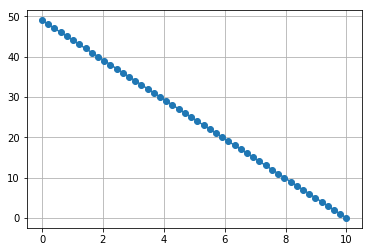

In [23]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, 10, len(model[1][-1][::-1])), model[1][-1][::-1], marker='o')
plt.grid(True)
plt.show()

In [25]:
model[1][-1][::-1]

array([49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33,
       32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16,
       15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

### 3. Complete dynamic programming

In [90]:
# INITIALIZATION
T = 5     # nb. of time steps
X = 5     # nb. of shares to liquidate
V = np.zeros((T, X))   # Value function
b = np.zeros((T, X))   # Policy iteration

In [91]:
# STOCK PATH (S)
S = np.zeros((T, X))
zeta = np.random.standard_normal((T, X))
sigma = 0.05
dt = 0.5
S[0] = 100.0
tau = 1.0
r = 0.05

for x in range(X):
    for t in range(1,T):
        S[t,x] = S[t-1,x] * np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*zeta[t,x])
        #print(S[t,x])
print(np.matrix(S))

[[ 100.          100.          100.          100.          100.        ]
 [ 101.96668838   98.54527058  106.19578359  110.8937671   107.20413549]
 [  96.33757768  102.00426596  109.67682431  112.64884835  116.73530193]
 [ 101.87172012  103.14904774  114.63821276  118.57157518  111.88514087]
 [ 109.49724202  110.30238139  121.10867124  119.3448891   119.8008095 ]]


In [92]:
# REVENU (R)
R = np.zeros((T, X))
for x in range(X):
    for t in range(1,T):
        R[t,x] = R[t-1,x] = x * (S[t,x] - g(x))

print(np.matrix(R))

[[   0.           98.54277058  212.38156717  332.65880131  428.77654196]
 [   0.          102.00176596  219.34364862  337.92404505  466.90120771]
 [   0.          103.14654774  229.26642551  355.69222555  447.50056349]
 [   0.          110.29988139  242.20734249  358.01216729  479.16323799]
 [   0.          110.29988139  242.20734249  358.01216729  479.16323799]]


In [103]:
# TERMINAL CONDITION
gamma = 0.5
for x in range(X):
    V[T-1,x] = np.exp(-gamma * (R[T-1,x] + x * (S[T-1,x] - 1)))
print(np.matrix(V).round(2))

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]


In [ ]:
# BACKWARD INDUCTION
for t in range(T-2,-1,-1):
    for x in range(X):
        best_value = 